# Google Speech Commands Dataset Recognition

- The objectives of this project are:
  - To understand how to preprocess audio files for machine learning
  - To develop a CNN using the extracted features
  - Create a prediction service using the trained model
  - Display the model training and diagram in Tensorboard
- We will take the Mel-frequency cepstral coefficients (MFCCs) and their deltas as our feature set
  - Used commonly for speech recognition and music classification

The Google Speech Command Dataset comes from this blog post: https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html

Librosa is an audio and music signal analysis package based on this paper: http://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf

More about librosa here: http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/index.html

Inspired by this Kaggle challenge: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import datetime
import json

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Configurations

In [10]:
# Set paths

# Google Dataset
data_path = "dataset"
# Data Extracted
json_path = "data.json"

# Path to label mappings
mapping_path = "mappings.json"

# H5 is the filetype specifed by Keras: https://www.tensorflow.org/guide/keras/save_and_serialize#keras_h5_format
saved_path = "model.h5"

# Model Constants
learning_rate = 0.001
epochs = 250
batch_size = 32 # This is the number of samples the CNN will see before updating with back-propagation
num_keywords = 31 # Number of classes in our set.

# Librosa constants

# 13 is a customary value used for number of MFCCs of audio classification
# The first 12-13 contain the most information (e.g. formants, spectral envelope)
num_coefficients = 13 
hop_length = 512 # How big our MFCC segments should be in number of frames.
n_fft = 2048 # How large the window of our Fast Fourier Transform will be.

# 1 second worth of sound based on the default settings from librosa
# 22050 samples in a second when loaded with librosa
# Audio files in Google voice command dataset have a duration of 1 second
sample_length = 22050 # This is equivalent to the Nyquist Frequeny of a CD

# Data Preprocessing

- Go through all data, extract features
- Store MFCCs in JSON file
- Extract 13 MFCC features, this is the standard from all the articles I read. Other values used are ca 45 and ca 90.
  - Then get the first and second-order MFCC deltas as additional features

### A look at the data

In [4]:
# Load an audio file
signal, sample_rate = librosa.load("test_audio/off.wav")
# Extract MFCCs
test_mfccs = librosa.feature.mfcc(y=signal, sr = sample_rate, n_mfcc=13)
test_mfccs.shape

(13, 44)

### Plotting the MFCCs
- Below is a plot of the MFCCs of one the test audio files.
  - You will notice that the Y-Axis has 13 rows and the X-Axis are the values of those coefficients over time

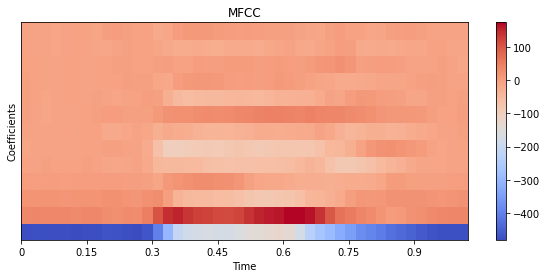

In [5]:
plt.figure(figsize=(10,4))
librosa.display.specshow(test_mfccs, x_axis="time", sr=sample_rate)
plt.title('MFCC')
plt.ylabel("Coefficients")
plt.colorbar()
plt.show()

### Adding the MFCC first and second-order deltas

In [6]:
test_mfccs_delta = librosa.feature.delta(test_mfccs)
test_mfccs_delta_2 = librosa.feature.delta(test_mfccs, order=2)
test_mfccs_features = np.concatenate((test_mfccs, test_mfccs_delta, test_mfccs_delta_2))
test_mfccs_features.shape

(39, 44)

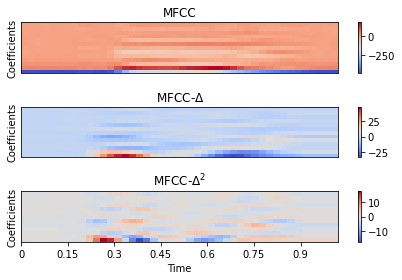

In [7]:
plt.subplot(3, 1, 1)
librosa.display.specshow(test_mfccs)
plt.title('MFCC')
plt.ylabel("Coefficients")
plt.colorbar()
plt.subplot(3, 1, 2)
librosa.display.specshow(test_mfccs_delta)
plt.title(r'MFCC-$\Delta$')
plt.ylabel("Coefficients")
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(test_mfccs_delta_2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.ylabel("Coefficients")
plt.colorbar()
plt.tight_layout()

## Extract data features from audio, store in JSON

In [8]:

def prep_data(data_path, json_path, num_coefficients=num_coefficients, hop_length=hop_length, n_fft=n_fft):
    
    # Dict containing, mappings of our words, their numerical labels, MFCCs, and paths to files.
    data = {
        "mappings": [],
        "labels": [],
        "mfccs": [],
        "files": []
    }
    
    # Loop through sub-directories
    # Find each directory, the subdirectories contained within, until we obtain filenames
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):
        # Check if at root level
        if dirpath is not data_path:
            # Update mapping
            cls = dirpath.split("/")[-1] #Grabs the last directory in path to use as a class name
            data["mappings"].append(cls)
            print("Processing: '{}'".format(cls))
            
            # For each file extract the MFCCs
            for filename in filenames:
                # Check filetype
                if not filename.lower().endswith(".wav"):
                    continue
                
                # Get path
                path = os.path.join(dirpath, filename)
                # Load audio file, librosa returns the signal and the sample rate
                # Sample rate is the number of samples we have per second of audio
                signal, sample_rate = librosa.load(path)
                # Check file is at least 1 second otherwise skip
                # We want to ensure that all samples have the same shape for neural network
                if len(signal) >= sample_length:
                    # Only consider the first second of data if longer
                    signal = signal[:sample_length]
                    
                    # Extract MFCCs, including the delta and second-order delta
                    mfccs = librosa.feature.mfcc(signal, n_mfcc=num_coefficients, hop_length=hop_length, n_fft=n_fft)
                    mfccs_delta = librosa.feature.delta(mfccs)
                    mfccs_delta_2 = librosa.feature.delta(mfccs, order=2)
                    mfccs_features = np.concatenate((mfccs, mfccs_delta, mfccs_delta_2))
                    # Store data in dict: labels, mfccs, filename
                    data["labels"].append(i-1) # Need to track i from the outer loop. -1 as we skipped root
                    data["mfccs"].append(mfccs_features.T.tolist()) # Librosa returns an ndarray, [T]ransform to a list
                    data["files"].append(path)
    
    keywords = data["mappings"]
    # Write data from dict to JSON file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    
    try:
        with open(mapping_path, "w") as mp:
            json.dump(data["mappings"], mp, indent=4)
    except:
        pass
        
    print("\nData Preparation Finished")


# Run data extraction process

In [9]:
if __name__ == "__main__":
    prep_data(data_path, json_path)

Processing: 'right'
Processing: 'eight'
Processing: 'cat'
Processing: 'tree'
Processing: 'bed'
Processing: 'happy'
Processing: 'go'
Processing: 'dog'
Processing: 'no'
Processing: 'wow'
Processing: 'nine'
Processing: 'left'
Processing: 'stop'
Processing: 'three'
Processing: '_background_noise_'
Processing: 'sheila'
Processing: 'one'
Processing: 'bird'
Processing: 'zero'
Processing: 'seven'
Processing: 'up'
Processing: 'marvin'
Processing: 'two'
Processing: 'house'
Processing: 'down'
Processing: 'six'
Processing: 'yes'
Processing: 'on'
Processing: 'five'
Processing: 'off'
Processing: 'four'

Data Preparation Finished


The extracted classes:

In [11]:
with open("mappings.json", "r") as fp:
    data = json.load(fp)
data

['right',
 'eight',
 'cat',
 'tree',
 'bed',
 'happy',
 'go',
 'dog',
 'no',
 'wow',
 'nine',
 'left',
 'stop',
 'three',
 '_background_noise_',
 'sheila',
 'one',
 'bird',
 'zero',
 'seven',
 'up',
 'marvin',
 'two',
 'house',
 'down',
 'six',
 'yes',
 'on',
 'five',
 'off',
 'four']

# Build the Convolutional Neural Network

In [12]:
def build_model(shape, learning_rate, error="sparse_categorical_crossentropy"):
    # Create CNN
    model = keras.Sequential()
    
    # Conv layers 1
    
    # First two parameters of Conv2D are our # filters (64), and kernel size (3,3)
    # kernel_regularization was recommended during research.
    model.add(keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=shape, 
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    
    # Conv Layer 2
    model.add(keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=shape, 
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    
    # Conv Layer 3 --> Down sampling
    model.add(keras.layers.Conv2D(32, (2,2), activation="relu", input_shape=shape, 
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding="same"))
    
    # Flatten output to dense layer as 1D array
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu"))
    # Dropout shuts down 30% of the neurons in dense layer during training stochastically
    # This will help the network train better by ensuring all neurons are involved in classification
    model.add(keras.layers.Dropout(0.2)) 
    
    # Softmax classifier
    model.add(keras.layers.Dense(num_keywords, activation="softmax")) # Output an array of prediction values, choose highest index
    
    # Compile Keras model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=error, metrics=["accuracy"])
    
    # Summary
    model.summary()
    
    return model

def load_data(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
        
    # Extract inputs and outputs, convert to np array.
    inputs = np.array(data["mfccs"])
    targets = np.array(data["labels"])
    
    return inputs, targets

def get_data_split(json_path, train_pct=0.2,validation_pct=0.1):
    # Load dataset
    x, y = load_data(json_path)
    
    # Shuffle
    shuffler = np.random.permutation(len(x))
    x = x[shuffler]
    y = y[shuffler]
    
    # Create splits for train, test, and validation
    train_pct_index = int(train_pct * len(x))
    x_train, x_test = x[:train_pct_index], x[train_pct_index:]
    y_train, y_test = y[:train_pct_index], y[train_pct_index:]
    
    x = x[shuffler]
    y = y[shuffler]
    
    validation_pct_index = int(validation_pct * len(x))
    x_train, x_validation = x_train[:validation_pct_index], x_train[validation_pct_index:]
    y_train, y_validation = y_train[:validation_pct_index], y_train[validation_pct_index:]
    
    # Convert inputs from 2d --> 3d
    x_train = x_train[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    
    return x_train, x_validation, x_test, y_train, y_validation, y_test

def main():
    # Data splits (train, test, validation)
    x_train, x_validation, x_test, y_train, y_validation, y_test = get_data_split(json_path)
    
    # Build CNN
    
    # A 3D tensor is needed for our CNN. The 3 dimensions being provided are:
    # Segments, we extracted MFCCs at equally spaced segments. This is based on the number of samples over hop_length
    # Number of coefficients, this is 39 as we extracted 13 MFCCs along with the first and second-order deltas.
    # Depth = 1, This depth is provided as we only have a single channel (MFCCs)... similar to a greyscale image.
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], )
    model = build_model(input_shape, learning_rate)
    
    #Create Callbacks for logs
    log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = keras.callbacks.TensorBoard(log_dir, write_graph=True, histogram_freq=1)
    
    # Train Model
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
              validation_data=(x_validation,y_validation), callbacks=[callbacks])
    
    # Evaluate Model
    test_error, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Error: {test_error}, Test Accuracy: {test_accuracy}")
    
    # Save Model
    model.save(saved_path)

# Run CNN Training

In [13]:
if __name__ == "__main__":
    main()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 37, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 37, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 19, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 17, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 9, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 8, 32)          4

Despite adding additional features, modifying the learning rate, changing the number of epochs, and other modifications to the model parameters, the validation accuracy remains in the 75-81% range. When investigating the data further is became apparent that a significant number files in the dataset contained bad audio samples. For example, the audio file below contains no speech. This may have limited the ability to train to a higher test/validation accuracy.

In [14]:
ipd.Audio("test_audio/bad_stop.wav")

# Build Recognition Service

In [32]:
def keyword_recognition():
    
    # Ensure there is only one instance (singleton) otherwise return existing instance.
    # This is for use with a Flask web server
    if Keyword_Recognizer.instance is None:
        Keyword_Recognizer.instance = Keyword_Recognizer()
        Keyword_Recognizer.model = keras.models.load_model(saved_path)
    
    return Keyword_Recognizer.instance


def get_mappings(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
        
    # Extract inputs and outputs, convert to np array.
    mappings = np.array(data["mappings"])
    
    return mappings

class Keyword_Recognizer:
    model = saved_path # This will be the model previously trained
    mappings = get_mappings(json_path)
    n_mfcc = num_coefficients
    hop_length = hop_length
    n_fft = n_fft
    
    instance = None
    
    def predict(self, audio_file_path):
        # Extract MFCCs
        mfccs = self.process_data(audio_file_path) # Shape: num segments, num coefficients
        
        # Convert 2d array into 4d array --> (num samples, num segments, num coefficients, num channels = 1 )
        # Keras accepts a batch of samples, so we must pass this
        mfccs = mfccs[np.newaxis, ..., np.newaxis]
        
        # Make prediction
        predictions = self.model.predict(mfccs) # [ [Array of scores] ]
        predicted_index = np.argmax(predictions) # Get index position
        predicted_keyword = self.mappings[predicted_index] # Get keyword at that index
        
        return predicted_keyword
        
    def process_data(self, audio_file_path, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft):
        # Load file
        signal, sample_rate = librosa.load(audio_file_path)
        # Enforce consistency
        if len(signal) >= sample_length:
        # Only consider the first second of data if longer
            signal = signal[:sample_length]
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(signal, n_mfcc=num_coefficients, hop_length=hop_length, n_fft=n_fft)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta_2 = librosa.feature.delta(mfccs, order=2)
        mfccs_features = np.concatenate((mfccs, mfccs_delta, mfccs_delta_2))
        
        return mfccs_features.T

# Test Predictions

## Test Files

In [16]:
audio1 = "test_audio/off.wav"
audio2 = "test_audio/eight.wav"
audio3 = "test_audio/stop.wav"

ipd.Audio(audio1)

In [17]:
ipd.Audio(audio2)

In [18]:
ipd.Audio(audio3)

## Run Prediction Service

In [33]:
if __name__ == "__main__":
    
    # Instantiate Class
    keyword_recognizer = keyword_recognition()
    
    # Make Predictions
    word_1 = keyword_recognizer.predict(audio1)
    word_2 = keyword_recognizer.predict(audio2)
    word_3 = keyword_recognizer.predict(audio3)

    
    print(f"First Prediction: {word_1}") # "Off"
    print(f"Second Prediction: {word_2}") # "Eight"
    print(f"Second Prediction: {word_3}") # "Stop"

First Prediction: off
Second Prediction: eight
Second Prediction: stop


In [21]:
%tensorboard --logdir logs